In [ ]:
import torch
from torch import nn
from torch.optim import Adam, SGD
from torch.nn import functional as F
from torch.utils.data import DataLoader

from torchvision.utils import save_image
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms as tf

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

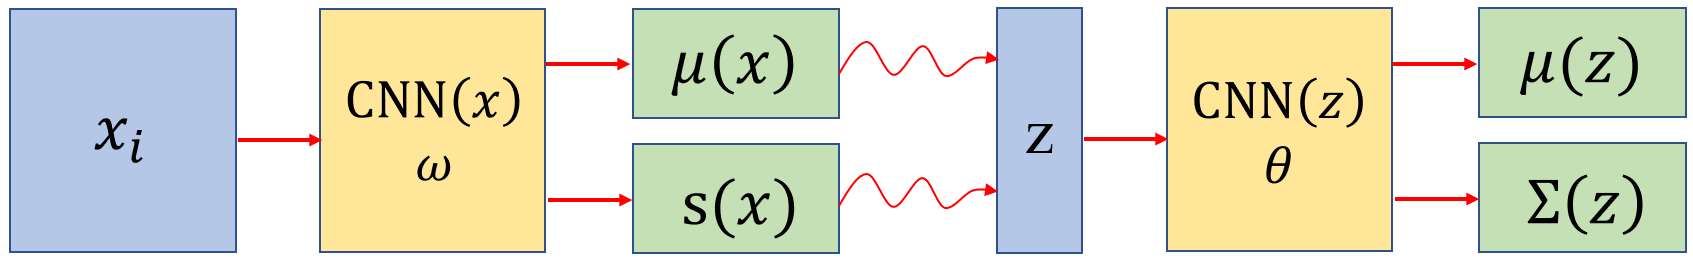

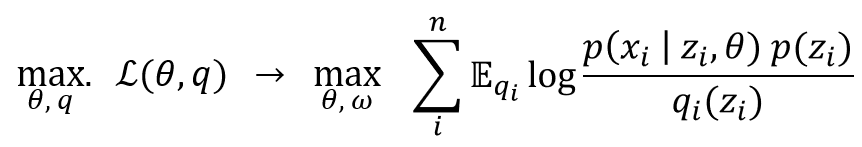

$\underset{\omega,\ \theta}{\mathrm{max.}}\ \ \ \mathbb{E}_{q_\omega(\mathbf{z|x})}[\mathrm{log}\ p_\theta(\mathbf{x|z})] - D_{KL}((q_{\omega}(\mathbf{z|x}) \parallel\ p_{\theta}(\mathbf{z})))$

where $q_\omega(\mathbf{z|x})$ represents the approximate posterior generated by the reocgnition model, while $p_\theta(\mathbf{z})$ is the prior over the latent space

$ -D_{KL}((q_{\omega}(\mathbf{z}) \parallel\ p_{\theta}(\mathbf{z}))) = \frac{1}{2}\sum_{j}(1 + \mathrm{log}((\sigma_j)^2) - \mu_j^2 - \sigma_j^2)$



Assuming a Bernoulli distribution for the decoder output $p_\theta(\mathbf{x|z})$, we obtain the following formula for the reconstruction error

log $p_\theta(\mathbf{x|z})\ =\ \sum_i x_i\ \mathrm{log} \ y_i + (1 - x_i)\ \mathrm{log}\ (1 - y_i)$

where $y$ is the reconstructed image

For a detailed description of the calculations have a look at
https://arxiv.org/abs/1312.6114
  

# Vanilla VAE

In [ ]:
class VVAE(nn.Module):
    def __init__(self, latent_size=20):
        super(VAE, self).__init__()
        """
        Init the vanilla VAE with fully conneccted layers only. 
        The layers fc21 and fc22 give the parameters of the approximate posterior
        over the latent space
        
        """
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, latent_size)
        self.fc22 = nn.Linear(400, latent_size)
        self.fc3 = nn.Linear(latent_size, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        """
        Encoder the input and generate the mean and the log of the variance
        for the Gaussian distributions

        """
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to move the random sampling outside of the 
        backward procedure

        """
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        """
        Reconstruct (or generate) an image

        """
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# DC VAE

In [ ]:
def con2d(in_ch, out_ch, k_size, bias):
    return nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=k_size, bias=bias)


def lin(in_feat, out_feat, bias):
    return nn.Linear(in_features=in_feat, out_features=out_feat, bias=bias)


class DCVAE(nn.Module):
    def __init__(self, latent_size):
        super(DCVAE, self).__init__()
        """
        Create a VAE with convolutional layers

        """
        self.activation = nn.ReLU()

        # Init the Encoder with a Sequential block
        self.encoder = nn.Sequential(
                          con2d(in_ch=1, out_ch=8, k_size=3, bias=True),
                          self.activation,
                          con2d(in_ch=8, out_ch=16, k_size=5, bias=True),
                          self.activation,
                          con2d(in_ch=16, out_ch=32, k_size=5, bias=True),
                          self.activation,
                          nn.Flatten(),
                          lin(in_feat=32*18*18, out_feat=latent_size*4, bias=True),
                          self.activation
        )

        # These two fc layers are used to generate the parameters of the 
        # posterior distributions
        self.fc1 = lin(in_feat=latent_size*4, out_feat=latent_size, bias=True)
        self.fc2 = lin(in_feat=latent_size*4, out_feat=latent_size, bias=True)

        # FC-section of the Decoder
        self.decoder_a = nn.Sequential(
                            lin(in_feat=latent_size, out_feat=32*18*18, bias=True),
                            
        )

        # Transposed convolutions for the second part of the Decoder. 
        # Notive the symmetry among the input and output channels of the transposed
        # convolutions of the Decoder and the convolutions in the Encoder
        self.decoder_b = nn.Sequential(
                            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5, bias=True),
                            self.activation,
                            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=5, bias=True),
                            self.activation,
                            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, bias=True)
        )
  
    def encode(self, x):
        o1 = self.activation(self.encoder(x))
        return self.fc1(o1), self.fc2(o1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        o1 = self.decoder_a(z)
        o1 = o1.view(o1.shape[0], 32, 18, 18)
        return torch.sigmoid(self.decoder_b(o1))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    """
    Evaluates the vae loss.
    The reconstruction loss is obtained considering a Bernoulli distribution for the 
    distribution p(x|z).
    For a detailed description of the calculations have a look at
    https://arxiv.org/abs/1312.6114

    """
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# VAE trainig

In [ ]:
latent_size = 30

In [ ]:
model = DCVAE(latent_size=latent_size)
model.to(device)

In [ ]:
optimizer = Adam(model.parameters(), lr=1.e-3, weight_decay=0.5e-6)

In [ ]:
kwargs = {'batch_size': 256, 'num_workers': 8, 'pin_memory': True}

train_loader = DataLoader(
                    MNIST('./mnist', train=True, download=True, transform=tf.ToTensor()),
                    shuffle=True, 
                    **kwargs
                )

test_loader = DataLoader(
                    MNIST('./mnist', train=False, download=True, transform=tf.ToTensor()),
                    **kwargs
                )

In [ ]:
def train(epoch):
    
    model.train()
    
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader, 1):
        data = data.to(device)
    
        recon_batch, mu, logvar = model(data)
        
        loss = loss_function(recon_batch, data, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        if batch_idx % (len(train_loader)//3) == 0:
            print(
                f'Train Epoch: {epoch} [{batch_idx}/{len(train_loader)}'
                f' ({batch_idx / len(train_loader) * 100:.0f}%)]'
                f'\tLoss: {train_loss / batch_idx:.4f}'
              )

    print(
        f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader):.4f}'
    )


In [ ]:
# Train the model
[train(epoch) for epoch in range(1, 20)]

In [ ]:
# Save model checkpoint
torch.save(model.state_dict(), './vae.pth')

In [ ]:
# Load model
model.load_state_dict(torch.load('./vae.pth'))

In [ ]:
# Test the model

model.eval()

test_loss = 0

with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
        data = data.to(device)

        recon_batch, mu, logvar = model(data)
        
        test_loss += loss_function(recon_batch, data, mu, logvar).item()
        
        if i == 0:
            n = min(data.size(0), 8)
            comparison = torch.cat([data[:n], recon_batch.view(data.shape[0], 1, 28, 28)[:n]])
            save_image(comparison.cpu(), './test_reconstruction_vae.png', nrow=n)

test_loss /= len(test_loader.dataset)
print(f'====> Test set loss: {test_loss:.4f}')

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(Image.open(f"./test_reconstruction_vae.png"))
plt.show()

In [ ]:
# Now we can check the inference capabilities of the VAEs.
# We need to randomly sample a point from a multivariate 
# standard normal distribution. 
# Such a point represents a latent vector and is the input
# for the decoder model

with torch.no_grad():
    sample = torch.randn(512, latent_size).to(device)
    img = model.decode(sample[:64, ...]).cpu()

save_image(img, './test_sample.png')

print(sample.shape, img.shape)

In [ ]:
plt.hist(sample.view(-1).cpu().numpy(), bins=30)
plt.show();

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(Image.open('./test_sample.png'))
plt.show()

# cVAE

$q_\omega(\mathbf{z|x})\ \rightarrow\ q_\omega(\mathbf{z|x,\ y})$

$p_\theta(\mathbf{x|z})\ \rightarrow\ p_\theta(\mathbf{x|z,\ y})$

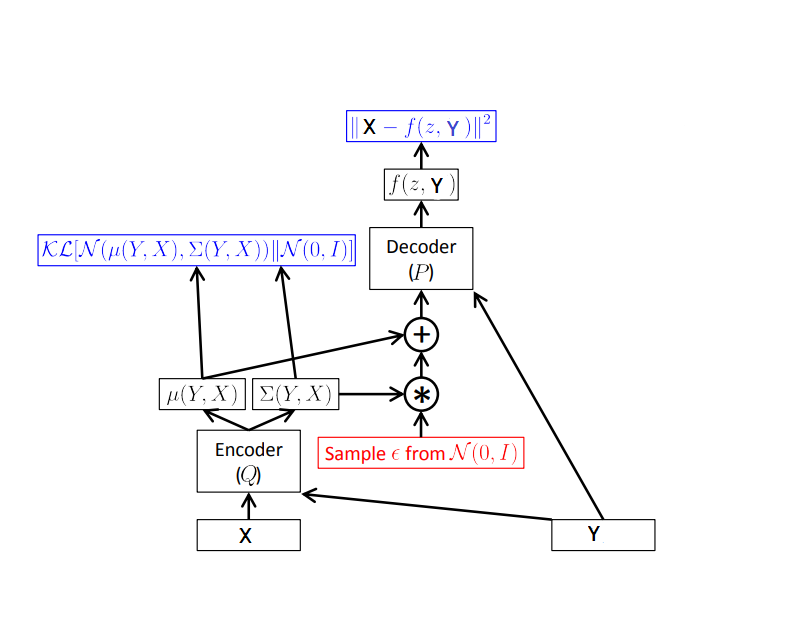

In [ ]:
def one_hot(y, classes):
    """
    0 to 9 labels --> one-hot encoding

    """
    targets = torch.zeros(y.shape[0], classes)
    for idx, label in enumerate(y):
        targets[idx, label] = 1
    return targets.to(device)

In [ ]:
class CVAE(nn.Module):
    def __init__(self, feature_size, latent_size, classes):
        super(CVAE, self).__init__()
        # Encoder
        self.fc1  = nn.Linear(feature_size + classes, 400)
        self.fc21 = nn.Linear(400, latent_size)
        self.fc22 = nn.Linear(400, latent_size)
        # Decoder
        self.fc3 = nn.Linear(latent_size + classes, 400)
        self.fc4 = nn.Linear(400, feature_size)

        self.activation = nn.ReLU()

    def encode(self, x, y): # q(z|x, y)
        inputs = torch.cat([x, y], 1)
        h1 = self.activation(self.fc1(inputs))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z, y): # p(x|z, y)
        inputs = torch.cat([z, y], 1)
        h3 = self.activation(self.fc3(inputs))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x, y):
        mu, logvar = self.encode(x.view(-1, 28*28), y)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, y), mu, logvar

In [ ]:
latent_size = 30

In [ ]:
# Create the model
cvae_model = CVAE(784, latent_size, 10).to(device)

In [ ]:
optimizer = Adam(cvae_model.parameters(), lr=1e-3, weight_decay=0.5e-6)

In [ ]:
def cvae_train(epoch):
    
    cvae_model.train()
    
    train_loss = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader, 1):
        data, labels = data.to(device), labels.to(device)
    
        labels = one_hot(labels, 10)
        recon_batch, mu, logvar = cvae_model(data, labels)
        
        loss = loss_function(recon_batch, data, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        if batch_idx % (len(train_loader)//3) == 0:
            print(
                f'Train Epoch: {epoch} [{batch_idx}/{len(train_loader)}'
                f' ({batch_idx / len(train_loader) * 100:.0f}%)]'
                f'\tLoss: {train_loss / batch_idx:.4f}'
              )

    print(
        f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader):.4f}'
    )


In [ ]:
# Train the CVAE
[cvae_train(epoch) for epoch in range(1, 20)]

In [ ]:
# Save model checkpoint
torch.save(cvae_model.state_dict(), './cvae.pth')

In [ ]:
# Load model checkpoint
cvae_model.load_state_dict(torch.load('./cvae.pth'))

In [ ]:
# Test the model

cvae_model.eval()

test_loss = 0

with torch.no_grad():
    for i, (data, labels) in enumerate(test_loader):
        data, labels = data.to(device), labels.to(device)

        labels = one_hot(labels, 10)
        
        recon_batch, mu, logvar = cvae_model(data, labels)
        test_loss += loss_function(recon_batch, data, mu, logvar).detach().cpu().numpy()
        
        if i == 0:
            n = min(data.size(0), 5)
            comparison = torch.cat([data[:n], recon_batch.view(-1, 1, 28, 28)[:n]])
            save_image(comparison.cpu(), 'test_reconstruction_cvae.png', nrow=n)

test_loss /= len(test_loader.dataset)
print(f'====> Test set loss: {test_loss:.4f}')

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(Image.open(f"./test_reconstruction_cvae.png"))
plt.show()

In [ ]:
with torch.no_grad():
    y = torch.eye(10, 10).cuda()
    sample = torch.randn(10, latent_size).to(device)
    sample = cvae_model.decode(sample, y).cpu()
    save_image(sample.view(10, 1, 28, 28), 'sample_cvae.png')

print(f'Sampled labels: {y.argmax(-1).cpu().numpy()}')

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(Image.open('./sample_cvae.png'))
plt.show();